# Finite Differences
Solving golden model 1 using central approximations for $\nabla^{2}$

In [1069]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## 1. Plot the actual solution

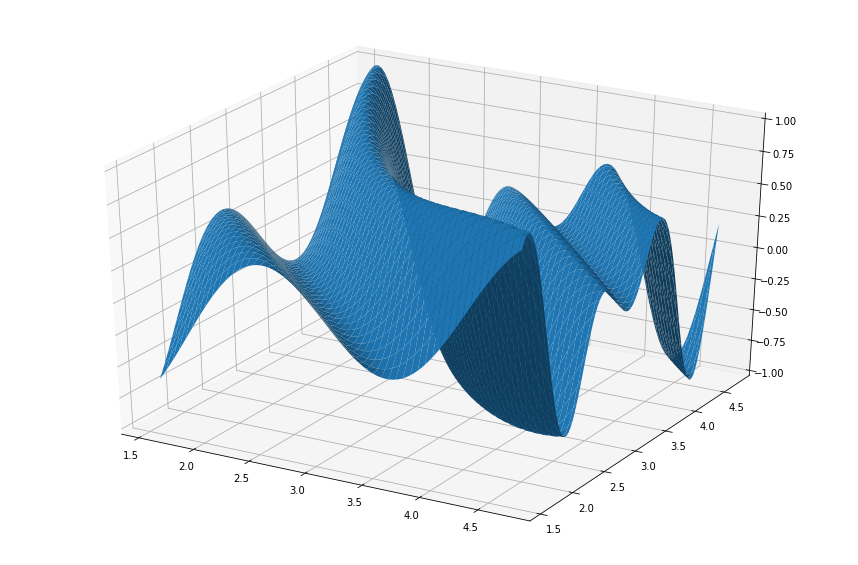

In [1070]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

x_start = np.pi / 2.0
x_end = 1.5 * np.pi
N = 100
x_delta = (x_end - x_start) / (N-1)

y_start = np.pi / 2.0
y_end = 1.5 * np.pi
N = 100
y_delta = (y_end - y_start) / (N-1)

X = np.arange(x_start, x_end+0.1*x_delta, x_delta)
Y = np.arange(y_start, y_end+0.1*y_delta, y_delta)
X, Y = np.meshgrid(X, Y)
Z = np.cos(X + Y) * np.sin(X*Y)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)

plt.show()

## 2. Time t=0, we have
Here we choose xy convention for how grid looks in numpy matrices. xy-convention means that

```python
x-grid = [[x0, x1, x2, x3], [x0, x1, x2, x3], ...]
y-grid = [[y0, y0, y0, y0], [y1, y1, y1, y1], [y2, y2, y2, y2]
```

In [1071]:
# helper to fill in the f-values
#def give_me_func(x_delta, y_delta):
#    def func(i, j):
#        x = i*x_delta
#        y = j*y_delta
#        return -np.cos(x+y)*np.sin(x*y)*(2 + x*x + y*y)- 2*np.sin(x+y)*np.cos(x*y)*(x+y)
#    return func

def compute_f_values(Nx, Ny, x_delta, y_delta, x_start, y_start):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i, j = np.meshgrid(i, j, indexing='xy')
    x = i*x_delta + x_start
    y = j*y_delta + y_start
    return -np.cos(x+y)*np.sin(x*y)*(2 + x*x + y*y)- 2*np.sin(x+y)*np.cos(x*y)*(x+y)

# x conditions
Nx = 100
x_start = np.pi * 0.5
x_end = np.pi * 1.5
x_delta = (x_end - x_start) / (Nx - 1)

# y conditions
Ny = 100
y_start = np.pi * 0.5
y_end = np.pi * 1.5
y_delta = (y_end - y_start) / (Ny - 1)

eps = 0.0001
tau = 0.0001

u_gold_func = lambda x,y: np.cos(x + y) * np.sin(x*y)
f_values = compute_f_values(Nx, Ny, x_delta, y_delta, x_start, y_start)

C = u_gold_func(np.pi*0.5, np.pi*.05)
u_values = np.zeros((Ny, Nx))
u_values.fill(C)
print 1.0 / (x_delta * x_delta), 1.0 / (y_delta * y_delta)

993.048920879 993.048920879


### 3. Define computations we need to perform
- computing matrix A
- computing vector b
- solver for $\textbf{A}u = b$

again, matrix A is identity in here

In [1072]:
def compute_vector_b(u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, verbose):
    i = np.arange(0, Nx, 1)
    j = np.arange(0, Ny, 1)
    i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
    x_mesh = i_mesh * x_delta + x_start
    y_mesh = j_mesh * y_delta + y_start
    
    # b values
    b = np.zeros((Ny, Nx))
    
    # boundary
    b[i_mesh==0] = u_gold_func(x_mesh[i_mesh==0], y_mesh[i_mesh==0])
    b[i_mesh==Nx-1] = u_gold_func(x_mesh[i_mesh==Nx-1], y_mesh[i_mesh==Nx-1])
    b[j_mesh==0] = u_gold_func(x_mesh[j_mesh==0], y_mesh[j_mesh==0])
    b[j_mesh==Ny-1] = u_gold_func(x_mesh[j_mesh==Ny-1], y_mesh[j_mesh==Ny-1])
    
    # internal network
    x_delta_2 = x_delta * x_delta
    y_delta_2 = y_delta * y_delta
    if verbose:
        print b
    lambda_x = (u_values[1:Ny-1, 2:Nx] - 2*u_values[1:Ny-1, 1:Nx-1] + u_values[1:Ny-1, 0:Nx-2]) / x_delta_2
    lambda_y = (u_values[2:Ny, 1:Nx-1] - 2*u_values[1:Ny-1, 1:Nx-1] + u_values[0:Ny-2, 1:Nx-1]) / y_delta_2
    update = tau * (lambda_x + lambda_y - f_values[1:Ny-1, 1:Nx-1])
    b[1:Ny-1, 1:Nx-1] = u_values[1:Ny-1, 1:Nx-1] + update
    if verbose:
        print lambda_x
        print lambda_y
        print (u_values[1, 2] - 2*u_values[1, 1] + u_values[1, 0]) / x_delta_2
        print (u_values[2, 1] - 2*u_values[1, 1] + u_values[0, 1]) / y_delta_2
        print lambda_x[0, 0]
        print lambda_y[0, 0]
        print update
        print b
    return b

def compute_max_eps(u_new, u, tau):
    return np.amax(np.abs(u_new - u))/tau

## 4. Run the Minimization
A single iteration can be used in here... this way you can step thru each iteration and visualize below

In [1073]:
# main minimization loop. 
condSatisfied = False
iterations = 0
max_iterations = 10000
verbose = False
printIterations = False
while not condSatisfied and iterations < max_iterations:
    b = compute_vector_b(u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, False)
    u_values_new = b # simple here
    max_eps = compute_max_eps(u_values_new, u_values, tau)
    if max_eps < eps: 
        condSatisfied = True
    if verbose:
        print u_values
        print u_values_new
        print u_values_new - u_values
    u_values = u_values_new
    iterations += 1
    if printIterations:
        print iterations, max_eps, eps
print iterations, max_eps, eps

10000 0.04617094077397077 0.0001


## 5. Plot Gold U-Function and approximated U-function

In [1074]:
X = np.arange(x_start, x_end+0.1*x_delta, x_delta)
Y = np.arange(y_start, y_end+0.1*y_delta, y_delta)
X, Y = np.meshgrid(X, Y)
u_gold = u_gold_func(X, Y)
show3d = True

## 5.1 Gold Model 3d

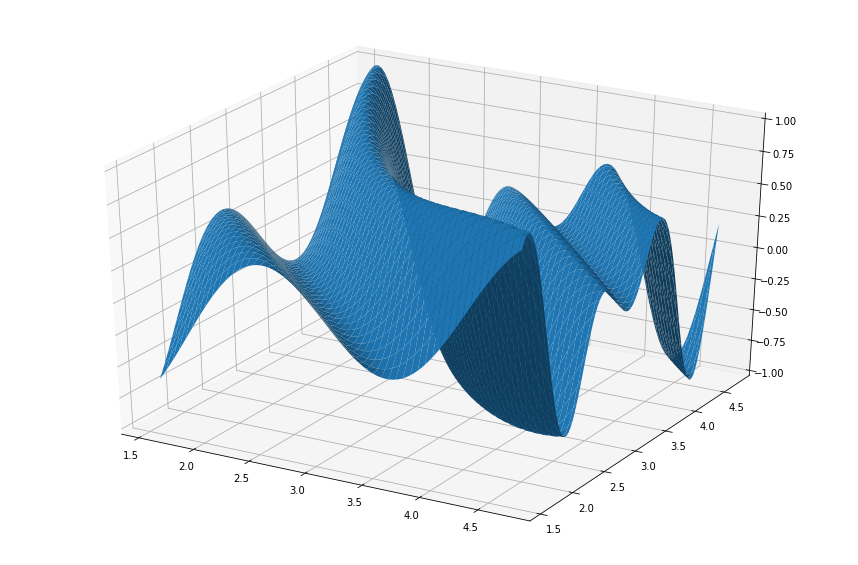

In [1075]:
if show3d:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    
    surf = ax.plot_surface(X, Y, u_gold)
    ax.set_zlim(-1, 1)

    plt.show()

## 5.2 Approximation 3d

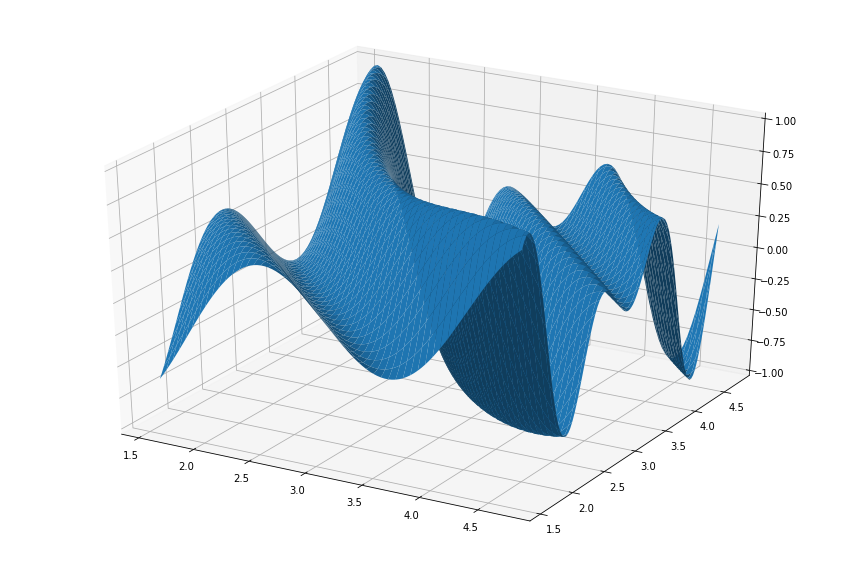

In [1076]:
if show3d:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, u_values)
    ax.set_zlim(-1, 1)

    plt.show()

## 6. Plot Errors
Here, I use simle errors - just the difference between values of the approximation and the golden model

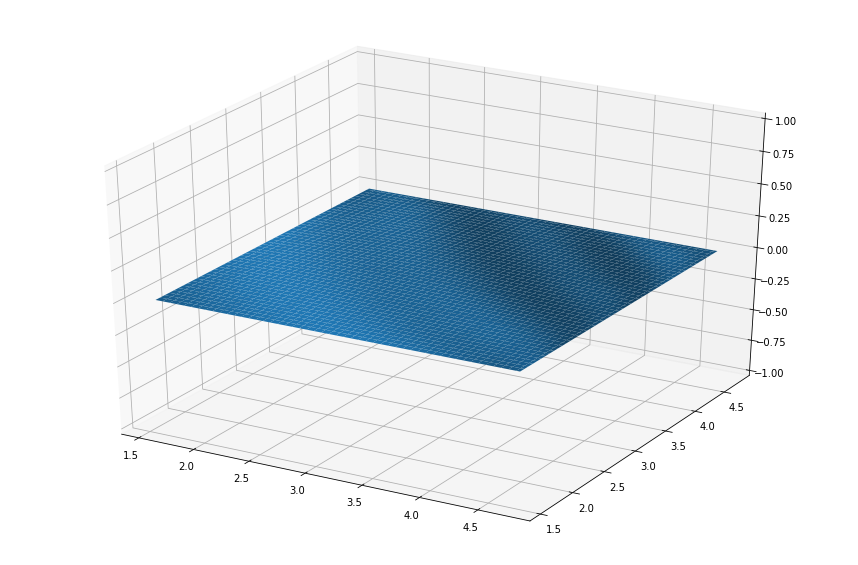

In [1077]:
if show3d:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    u_gold = u_gold_func(X, Y)
    surf = ax.plot_surface(X, Y, u_gold - u_values)
    ax.set_zlim(-1, 1)

    plt.show()

## 7. For a clear view, let's plot projections for either dimension

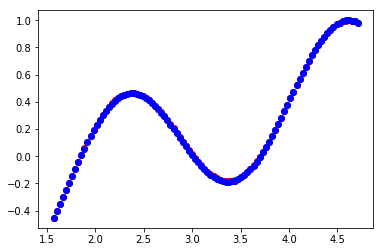

In [1078]:
projection = 4

plt.plot(X[0], u_gold[projection], 'ro', X[0], u_values[projection], 'bo')
plt.show()

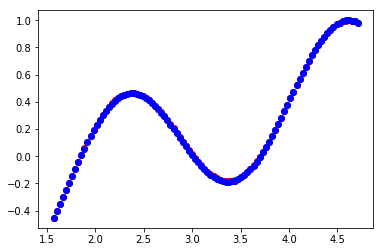

In [1079]:
plt.plot(Y[:, 0], u_gold[:, projection], 'ro', Y[:, 0], u_values[:, projection], 'bo')
plt.show()